# Regression Discontinuity

## Regression Discontinuity with Ordinary Least Squares

### Plot of binned means

In [ ]:
install.packages('causaldata')
install.packages('modelsummary')
install.packages('gmm')
install.packages('gmm')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘webshot’, ‘bayestestR’, ‘datawizard’, ‘checkmate’, ‘kableExtra’, ‘insight’, ‘parameters’, ‘performance’, ‘tables’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘zoo’, ‘sandwich’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


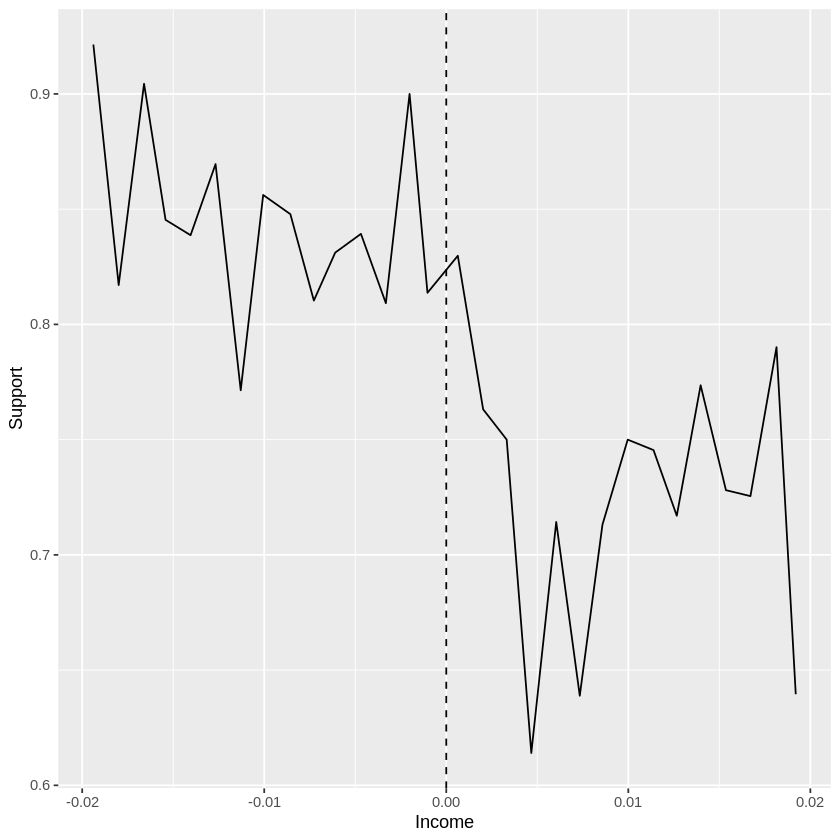

In [ ]:
library(tidyverse)
gt <- causaldata::gov_transfers

# Use cut() to create bins, using breaks to make sure it breaks at 0
# (-15:15)*.02/15 gives 15 breaks from -.02 to .02
binned <- gt %>%
    mutate(Inc_Bins = cut(Income_Centered,
           breaks = (-15:15)*(.02/15))) %>%
    group_by(Inc_Bins) %>%
    summarize(Support = mean(Support),
    Income = mean(Income_Centered))
# Taking the mean of Income lets us plot data roughly at the bin midpoints

ggplot(binned, aes(x = Income, y = Support)) +
    geom_line() +
    # Add a cutoff line
    geom_vline(aes(xintercept = 0), linetype = 'dashed')

A little extra theming gets us Figure 20.10.2525. There’s definitely a break at the cutoff there, and some higher support to the left of the cutoff (treatment is to the left here since you need low income to get paid) that isn’t what we’d expect by following the trend on the right of the cutoff.

### First step to performing RV

In [ ]:
library(tidyverse); library(modelsummary);library(IRdisplay);library(htmltools)
gt <- causaldata::gov_transfers

# Linear term and a squared term with "treated" interactions
m <- lm(Support ~ Income_Centered*Participation +
       I(Income_Centered^2)*Participation, data = gt)

# Add a triangular kernel weight
kweight <- function(x) {
    # To start at a weight of 0 at x = 0, and impose a bandwidth of .01,
    # we need a "slope" of -1/.01 = 100,
    # and to go in either direction use the absolute value
    w <- 1 - 100*abs(x)
    # if further away than .01, the weight is 0, not negative
    w <- ifelse(w < 0, 0, w)
    return(w)
}

# Run the same model but with the weight
mw <- lm(Support ~ Income_Centered*Participation, data = gt,
         weights = kweight(Income_Centered))

# See the results with heteroskedasticity-robust SEs
results <- msummary(list('Quadratic' = m, 'Linear with Kernel Weight' = mw),
    stars = c('*' = .1, '**' = .05, '***' = .01), vcov = 'robust')


display_html(results[1])

Warning message in residuals^2/(1 - diaghat)^2:
“longer object length is not a multiple of shorter object length”


,Quadratic,Linear with Kernel Weight
(Intercept),0.769***,0.819***
,(0.034),(0.015)
Income_Centered,−11.567,−23.697***
,(8.101),(3.219)
Participation,0.093**,0.033
,(0.044),(0.021)
I(Income_Centered^2),562.247,
,(401.982),
Income_Centered × Participation,19.300*,26.594***
,(10.322),(4.433)


**Second**, it will properly implement local regression with your polynomial order of choice (linear by default) and a triangular kernel.

**Third**, as implied by the name, it will apply heteroskedasticity-robust standard errors. Specifically, it uses a robust standard error estimator that takes into account the structure of the regression discontinuity problem. It looks for each observation’s nearest neighbors along the running variable, and uses that information to figure out the amount of heteroskedasticity and how to correct for it.

 **Fourth** step: bias correction:
 Methods for optimal bandwidth choice tend to select bandwidths that are wide, so as to help increase the effective sample size and improve precision. However, estimates of standard errors rely on our idea of what the distribution of the error term is. And those wide bandwidths futz up what those distributions look like. So there is a method here to correct for that bias, improving the estimate of the standard error.


In [ ]:
install.packages('rdrobust')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Warning message in rdrobust(gt$Support, gt$Income_Centered, c = 0):
“Mass points detected in the running variable.”


Sharp RD estimates using local polynomial regression.

Number of Obs.                 1948
BW type                       mserd
Kernel                   Triangular
VCE method                       NN

Number of Obs.                 1127          821
Eff. Number of Obs.             291          194
Order est. (p)                    1            1
Order bias  (q)                   2            2
BW est. (h)                   0.005        0.005
BW bias (b)                   0.010        0.010
rho (h/b)                     0.509        0.509
Unique Obs.                     841          639

        Method     Coef. Std. Err.         z     P>|z|      [ 95% C.I. ]       
  Conventional     0.025     0.062     0.396     0.692    [-0.098 , 0.147]     
        Robust         -         -     0.624     0.533    [-0.097 , 0.188]     
[1] "Mass points detected in the running variable."


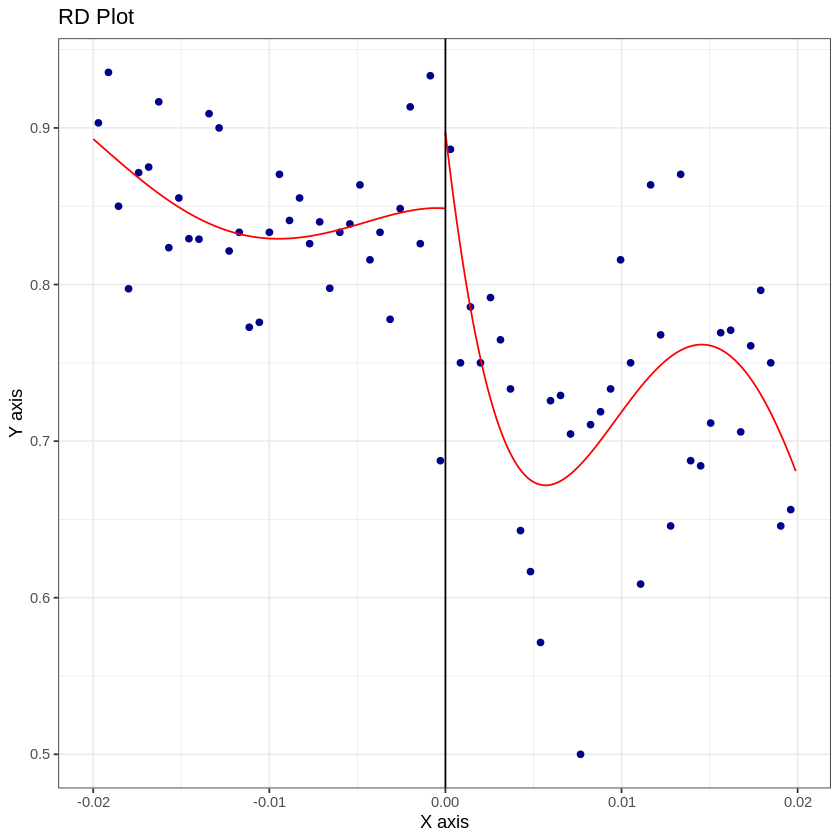

In [ ]:
library(tidyverse); library(rdrobust)
gt <- causaldata::gov_transfers

# Estimate regression discontinuity and plot it
m <- rdrobust(gt$Support, gt$Income_Centered, c = 0)
summary(m)
# Note, by default, rdrobust and rdplot use different numbers
# of polynomial terms. You can set the p option to standardize them.
rdplot(gt$Support, gt$Income_Centered)

## Fuzzy Regression Discontinuity

### Full estimation:
 First we’ll do it ourselves using the instrumental variables code we used in Chapter 19. We’re using the running variable quarter of birth (qob), which has been centered on the quarter of birth you’d need to be to be eligible for a mortgage subsidy for fighting in the Korean War (qob_minus_kw). This determines whether you were a veteran of either the Korean War or World War II (vet_wwko). All of this is to see if veteran status (and its accompanying mortgage subsidies) affects your home ownership status (home_ownership) - remember, the goal here is looking for the effect of those mortgage subsidies. There are also controls for being white or nonwhite, and your birth state.

To keep things simple, we’ll apply a bandwidth before doing estimation, we’ll skip the kernel weighting, and we’ll just do a linear model. The code we did before for incorporating these things still works here, though, if you want to add them.

In [ ]:
install.packages('fixest')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Formula’, ‘numDeriv’, ‘Rcpp’, ‘dreamerr’




In [ ]:
 library(fixest)
vet <- causaldata::mortgages

# Create an "above-cutoff" variable as the instrument
vet <- vet %>% mutate(above = qob_minus_kw > 0)

# Impose a bandwidth of 12 quarters on either side
vet <- vet %>%  filter(abs(qob_minus_kw) < 12)

m <- feols(home_ownership ~
    nonwhite  | # Control for race
    bpl + qob | # fixed effect controls
    qob_minus_kw*vet_wwko ~ # Instrument our standard RDD
    qob_minus_kw*above, # with being above the cutoff
    se = 'hetero', # heteroskedasticity-robust SEs
    data = vet)

# And look at the results
results <- msummary(m, stars = c('*' = .1, '**' = .05, '***' = .01))

display_html(toString(results))

,(1)
fit_qob_minus_kw,−0.007***
,(0.002)
fit_vet_wwko,0.170***
,(0.046)
fit_qob_minus_kw × vet_wwko,−0.003
,(0.003)
nonwhite,−0.190***
,(0.007)
Num.Obs.,56901
R2,0.053


These show that veteran status at this margin increases home ownership rates by 17 percentage points. Not bad. We could also apply the exact same regression discontinuity plot code from last time (there’s no special “fuzzy” plot, although now we’d call the typical regression discontinuity plot the “second stage” plot), and also apply that plot code using the treatment variable as an outcome (the “first stage”), to make sure that the assignment variable is working as expected. This gives us Figure 20.13.3333 However big the resulting jump is in Figure 20.13 (b) is the fuzzy RDD estimate - it’s how much of a jump you’d expect if everybody went from untreated to treated (0% to 100%). It looks good! We definitely see a sharp change in the rate of eligible veterans around the cutoff, and we see a discontinuity in the rate of home ownership at the same point. The fuzzy RDD estimate is the jump at the cutoff in Figure 20.13 (b) divided by the jump in the cutoff in Figure 20.13 (a).

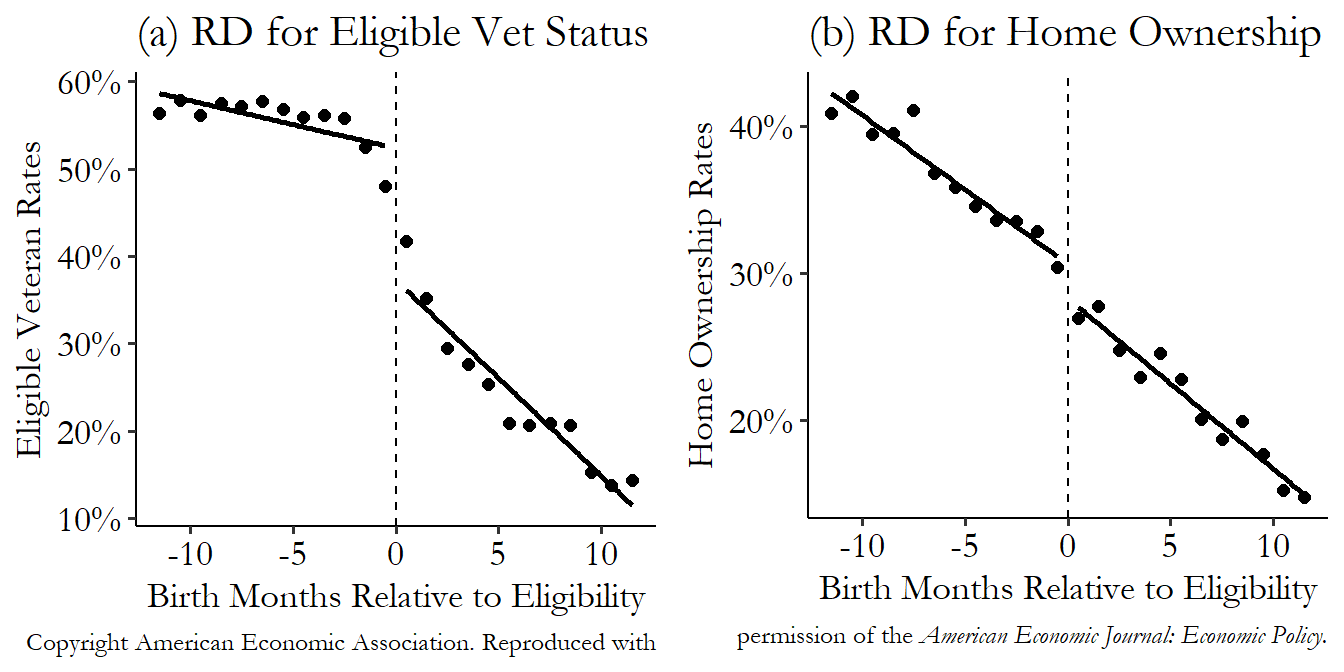

## The Density Discontinuity Test

### Treatment status indicator
Next we can, as before, use the rdrobust function in R and Stata, to do local polynomial regression, kernel weighting, easy graphs, all that good stuff. We just need to use vet_wwko as our “treatment status indicator” and give that to the fuzzy option.

In [ ]:
library(tidyverse); library(rdrobust)
vet <- causaldata::mortgages

# It will apply a bandwidth anyway, but having it
# check the whole bandwidth space will be slow. So let's
# pre-limit it to a reasonable range of 12 quarters
vet <- vet %>%
    filter(abs(qob_minus_kw) <= 12)

# Create our matrix of controls
controls <- vet %>%
    select(nonwhite, bpl, qob) %>%
    mutate(qob = factor(qob))
# and make it a matrix with dummies
conmatrix <- model.matrix(~., data = controls)

# This is fairly slow due to the controls, beware!
m <- rdrobust(vet$home_ownership,
              vet$qob_minus_kw,
              fuzzy = vet$vet_wwko,
              c = 0,
              covs = conmatrix)

summary(m)

Warning message in rdrobust(vet$home_ownership, vet$qob_minus_kw, fuzzy = vet$vet_wwko, :
“Multicollinearity issue detected in covs. Redundant covariates dropped.”
Warning message in rdrobust(vet$home_ownership, vet$qob_minus_kw, fuzzy = vet$vet_wwko, :
“Mass points detected in the running variable.”


Covariate-adjusted Fuzzy RD estimates using local polynomial regression.

Number of Obs.                56901
BW type                       mserd
Kernel                   Triangular
VCE method                       NN

Number of Obs.                28776        28125
Eff. Number of Obs.            6911         6756
Order est. (p)                    1            1
Order bias  (q)                   2            2
BW est. (h)                   3.387        3.387
BW bias (b)                   5.354        5.354
rho (h/b)                     0.633        0.633
Unique Obs.                      12           12

First-stage estimates.

        Method     Coef. Std. Err.         z     P>|z|      [ 95% C.I. ]       
  Conventional    -0.262     0.018   -14.411     0.000    [-0.298 , -0.226]    
        Robust         -         -   -13.776     0.000    [-0.352 , -0.265]    

Treatment effect estimates.

        Method     Coef. Std. Err.         z     P>|z|      [ 95% C.I. ]       
  Conventional

### Density Test

Before running our code we can ask ourselves about the potential for manipulation here. The government assigned treatment on the basis of not just one characteristic, but a sum of a whole bunch of things. It determined that process before knowing exactly who would qualify (making it hard for the government to manipulate). The whole process wasn’t fully obvious (making it hard for people to manipulate), and it would be difficult to know beforehand exactly how close to the cutoff you were (making it hard to know if you should bother trying to manipulate).

So it seems unlikely that this particular study will show evidence of manipulation. But you never know! Let’s see. This test uses a slightly expanded version of the data including people who weren’t surveyed at the right time to be included in the study, and those outside the bandwidth used in estimation (so we limit to the bandwidth ourselves).

In [ ]:
install.packages('rddensity')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘lpdensity’




In [ ]:
library(rddensity)
gt <- causaldata::gov_transfers_density  %>%
   filter(abs(Income_Centered) < .02)

# Estimate the discontinuity
gt %>%
    pull(Income_Centered) %>%
    rddensity(c = 0) %>%
    summary()


Manipulation testing using local polynomial density estimation.

Number of obs =       20463
Model =               unrestricted
Kernel =              triangular
BW method =           estimated
VCE method =          jackknife

c = 0                 Left of c           Right of c          
Number of obs         9077                11386               
Eff. Number of obs    1927                2309                
Order est. (p)        2                   2                   
Order bias (q)        3                   3                   
BW est. (h)           0.004               0.005               

Method                T                   P > |T|             
Robust                -0.9238             0.3556              



Warning message in summary.CJMrddensity(.):
“There are repeated observations. Point estimates and standard errors have been adjusted. Use option massPoints=FALSE to suppress this feature.”



P-values of binomial tests (H0: p=0.5).

Window Length / 2          <c     >=c    P>|T|
0.000                      24      20    0.6516
0.000                      50     104    0.0000
0.000                      70     123    0.0002
0.000                      79     157    0.0000
0.000                     109     176    0.0001
0.000                     141     195    0.0038
0.000                     160     216    0.0045
0.000                     184     237    0.0112
0.000                     199     254    0.0111
0.000                     226     270    0.0534
